In [51]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages, get_6montages
import mne
from scipy import signal as sig
import ruptures as rpt

import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

In [7]:
training_folder = "../../test/"

In [8]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) 
# Importiere EKG-Dateien, zugehörige Diagnose, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz)

1000	 Dateien wurden geladen.


# Criando mais datasets

In [63]:
headers = ['Sinal','Seizure','Onset','Offset']
df = pd.read_csv('../../shared_data/training/REFERENCE.csv', names=headers)

In [64]:
df

,Sinal,Seizure,Onset,Offset
0,aaaaaapo_s002_t000,0,0.0000,0.0000
1,aaaaaasf_s001_t000_1,1,42.2786,81.7760
2,aaaaaasf_s001_t000_2,1,26.0120,54.3185
3,aaaaaasf_s001_t000_3,1,30.2640,53.7680
4,aaaaaasf_s001_t000_4,1,22.6400,47.6720
...,...,...,...,...
6208,aaaaappz_s002_t001,0,0.0000,0.0000
6209,aaaaardk_s001_t019_1,1,263.1762,324.0300
6210,aaaaardk_s001_t019_2,1,205.9743,269.0987
6211,aaaaakpu_s003_t003,0,0.0000,0.0000


In [65]:
from pathlib import Path
path = Path('../../test_5/')
files = [file.stem for file in path.rglob('*')]

In [66]:
len(files)

1438

In [67]:
files.sort()

In [68]:
mask = df['Sinal'].isin(files)
new = df[mask]

In [69]:
new.reset_index(drop=True)

,Sinal,Seizure,Onset,Offset
0,aaaaapnl_s004_t001,0,0.0000,0.0000
1,aaaaapnl_s005_t009,0,0.0000,0.0000
2,aaaaapnl_s007_t009,0,0.0000,0.0000
3,aaaaapnl_s008_t010,0,0.0000,0.0000
4,aaaaaqtu_s011_t000,0,0.0000,0.0000
...,...,...,...,...
1433,aaaaasjq_s004_t000,0,0.0000,0.0000
1434,aaaaaqvr_s003_t000,0,0.0000,0.0000
1435,aaaaappz_s002_t001,0,0.0000,0.0000
1436,aaaaardk_s001_t019_1,1,263.1762,324.0300


In [70]:
filepath = Path('../../test_5/REFERENCE.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new.to_csv(filepath, index=False, header=None)  

# Visualizando Dataset

In [9]:
# Creatinf dataframe for visualization
df = pd.DataFrame({'ids': ids, 'channels': channels, 'data':data, 'sampling_frequencies': sampling_frequencies, 'reference_systems': reference_systems, 'eeg_labels': eeg_labels})

In [10]:
df

,ids,channels,data,sampling_frequencies,reference_systems,eeg_labels
0,aaaaaaac_s001_t000,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-2.9907242042298652e-05, -3.479005706961272e...",250,LE,"(1, 36.8868, 237.2101)"
1,aaaaaaac_s001_t001,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[3.9367696157719664e-05, 3.753664052247688e-0...",250,LE,"(1, 12.0764, 200.3233)"
2,aaaaaaac_s002_t000,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[0.00013549811700796534, 0.000128173894466994...",250,LE,"(1, 16.0173, 218.0379)"
3,aaaaaaac_s004_t000,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-1.2207037568285165e-06, -6.103518784142582e...",250,LE,"(0, 0.0, 0.0)"
4,aaaaaaac_s004_t002,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-1.800538041322062e-05, -1.770020447401349e-...",250,LE,"(0, 0.0, 0.0)"
...,...,...,...,...,...,...
995,aaaaagoo_s004_t003,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[1.2606928006838183e-05, 1.4406489150671918e-...",400,AR,"(0, 0.0, 0.0)"
996,aaaaagoo_s005_t000,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-1.978517258216905e-05, -1.7985611438335315e...",400,AR,"(0, 0.0, 0.0)"
997,aaaaagoo_s005_t001,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-9.887586291083506e-06, -1.2586928006834109e...",400,AR,"(0, 0.0, 0.0)"
998,aaaaagoo_s005_t002,"[Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7,...","[[-7.188244575332903e-06, -8.08802514724977e-0...",400,AR,"(0, 0.0, 0.0)"


In [11]:
seizure_df = df[df.eeg_labels != (0,0.0,0.0)]
seizure_df.shape

(360, 6)

In [7]:
idx_record = 78

new_montage, new_data, is_missing = get_3montages(channels[idx_record], data[idx_record])
print("Alle Montagen wurden berechnet: ", not is_missing)
print("Montagen: ",new_montage)
print("Signal Dimension: ", new_data.shape)

Alle Montagen wurden berechnet:  True
Montagen:  ['Fp1-F3', 'Fp2-F4', 'C3-P3']
Signal Dimension:  (3, 10193)


0 Fp1-F3
0.0002539063814203315
1 Fp2-F4
0
2 C3-P3
-0.0002539063814203315


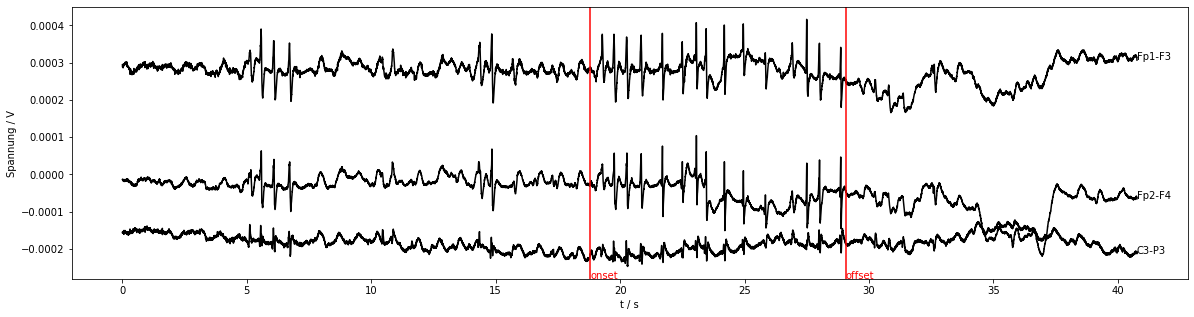

In [8]:
fig, axs = plt.subplots(figsize=[20,5])
max_diff=new_data.max()-new_data.min()
time_ax = np.arange(new_data.shape[1])/sampling_frequencies[idx_record]
_off_sets = [max_diff/1.5,0,-max_diff/1.5]
_labels = eeg_labels[idx_record]

for i, _montage in enumerate(new_montage):
    print(i, _montage)
    print(_off_sets[i])
    plt.plot(time_ax,new_data[i,:]+_off_sets[i],'k')
    plt.text(time_ax[-1], new_data[i,-1]+_off_sets[i], _montage)
if _labels[0]:
    plt.axvline(x = _labels[1], color = 'r', label = 'onset')
    plt.text(_labels[1], axs.get_ylim()[0], 'onset',color='r')  
    plt.axvline(x = _labels[2], color = 'r', label = 'offset')
    plt.text(_labels[2], axs.get_ylim()[0], 'offset',color='r')   
plt.xlabel("t / s")
plt.ylabel("Spannung / V")
plt.show()

#idx_record = 78

# Detecção de convulsão

In [61]:
# Código do Manu (Features)
import pywt
wavelet = 'db4'
dataset_montage_line_length_array = np.zeros((len(ids),15))
for i,_id in enumerate(ids):
    montage, montage_data, is_missing = get_3montages(channels[i], data[i])
    montage_line_length_array = np.zeros((15))
    for j, signal_name in enumerate(montage):
        ca4, cd4, cd3, cd2, cd1 = pywt.wavedec(montage_data[j], wavelet, level=4)
        montage_line_length_array[(5*j)] = np.sum(np.abs(np.diff(ca4)))/len(ca4)
        montage_line_length_array[(5*j)+1] = np.sum(np.abs(np.diff(cd4)))/len(cd4)
        montage_line_length_array[(5*j)+2] = np.sum(np.abs(np.diff(cd3)))/len(cd3)
        montage_line_length_array[(5*j)+3] = np.sum(np.abs(np.diff(cd2)))/len(cd2)
        montage_line_length_array[(5*j)+4] = np.sum(np.abs(np.diff(cd1)))/len(cd1)
    dataset_montage_line_length_array[i] = montage_line_length_array

features = dataset_montage_line_length_array
labels = np.array(eeg_labels, dtype=int)[:,0]

## Creating 9 Features

In [5]:
# Código da Sophia (Features)
import numpy as np
from scipy.stats import kurtosis, skew
import antropy as ant

feature = np.zeros((len(ids),(36))) # Empty array for all 9 features for every montage of every id
for i,_id in enumerate(ids):
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], data[i])
    _fs = sampling_frequencies[i]
    id_feature = np.zeros(36)
    
    sum_min = 0
    sum_max = 0
    sum_mean = 0
    sum_ll = 0
    sum_std = 0
    sum_kurtosis = 0
    sum_skew = 0
    sum_en = 0
    sum_entspec = 0
        
    m = 0
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        """Feature calculation"""
        sig_min = np.min(signal_filter) # Min
        sig_max = np.max(signal_filter) # Max
        sig_mean = np.mean(signal_filter) # Mean
        sig_ll = np.sum(np.abs(np.diff(signal_filter))) # Line Length
        sig_std = np.std(signal_filter) #Std Dev
        sig_kurtosis = kurtosis(signal_filter.tolist()) #Kurtosis
        sig_skew = skew(signal_filter.tolist()) #Skewness
        sig_en = np.mean(signal_filter**2) #Energy 
        sig_entspec = ant.spectral_entropy(signal_filter,_fs,method='fft') # Entropy Spectral
        
        sum_min += sig_min
        sum_max += sig_max
        sum_mean += sig_mean
        sum_ll += sig_ll
        sum_std += sig_std
        sum_kurtosis += sig_kurtosis
        sum_skew += sig_skew
        sum_en += sig_en
        sum_entspec += sig_entspec
        
        id_feature[m:(m+9)] = np.array([sig_min, sig_max, sig_mean, sig_ll, sig_std, sig_kurtosis, sig_skew, sig_en, sig_entspec])
        m += 9
    
    sum_features = np.array([sum_min, sum_max, sum_mean, sum_ll, sum_std, sum_kurtosis, sum_skew, sum_en, sum_entspec])
    mean_features = sum_features/3
    id_feature[27:36] = mean_features
    
    feature[i,:] = id_feature
    
labels = np.array(eeg_labels, dtype=int)[:,0]

In [6]:
np.shape(feature)

(100, 36)

## Selecting most important features with Mutual Information

In [7]:
column_values = ['a_min','a_max','a_mean','a_ll','a_std','a_kurt','a_skew','a_energy','a_ent',
                 'b_min','b_max','b_mean','b_ll','b_std','b_kurt','b_skew','b_energy','b_ent',
                 'c_min','c_max','c_mean','c_ll','c_std','c_kurt','c_skew','c_energy','c_ent',
                'mean_min','mean_max','mean_mean','mean_ll','mean_std','mean_kurt','mean_skew','mean_energy','mean_ent']
df_features = pd.DataFrame(data = feature,
                  index = ids,
                  columns = column_values)

In [104]:
df_features

,a_min,a_max,a_mean,a_ll,a_std,a_kurt,a_skew,a_energy,a_ent,b_min,...,c_ent,mean_min,mean_max,mean_mean,mean_ll,mean_std,mean_kurt,mean_skew,mean_energy,mean_ent
aaaaaaac_s001_t000,-0.000403,0.000756,-2.518393e-08,0.761896,0.000065,30.181350,2.122000,4.229286e-09,8.538290,-0.000366,...,7.662955,-0.000509,0.000534,-1.495481e-08,1.444611,0.000056,30.414690,-0.310529,3.196348e-09,8.536517
aaaaaaac_s001_t001,-0.000638,0.001044,-1.079411e-07,0.613754,0.000069,54.928446,2.725136,4.714131e-09,8.437336,-0.000498,...,7.573655,-0.001004,0.001209,-4.699252e-08,0.959405,0.000091,48.648511,1.763064,1.051843e-08,8.687730
aaaaaaac_s002_t000,-0.000403,0.000756,-8.085566e-08,0.706950,0.000069,26.500566,2.013740,4.807908e-09,8.262338,-0.000366,...,7.919337,-0.000387,0.000470,-4.831043e-08,1.285778,0.000054,16.350105,0.277777,3.020805e-09,8.535922
aaaaaaac_s004_t000,-0.000076,0.000074,3.601219e-08,0.141379,0.000017,0.611065,0.465449,2.918264e-10,9.522633,-0.000059,...,9.671354,-0.000060,0.000058,5.425116e-09,0.134003,0.000013,0.615204,0.298646,1.798240e-10,9.599328
aaaaaaac_s004_t002,-0.000062,0.000103,-2.733309e-09,0.291546,0.000016,0.694327,0.561494,2.720081e-10,10.567966,-0.000047,...,10.742889,-0.000049,0.000077,7.929127e-10,0.252890,0.000012,0.609761,0.399407,1.654796e-10,10.674478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aaaaaasy_s003_t012,-0.000115,0.000145,-1.008049e-07,0.037778,0.000017,10.706415,-0.985853,2.837300e-10,9.585037,-0.000105,...,8.632728,-0.000090,0.000106,-1.101722e-07,0.044731,0.000014,6.945387,-0.458098,1.945164e-10,9.467980
aaaaaasy_s003_t013,-0.000114,0.000109,5.950370e-08,0.022050,0.000013,13.822834,-1.206703,1.814302e-10,8.992621,-0.000091,...,7.571300,-0.000082,0.000086,5.617829e-08,0.021556,0.000011,8.100090,-0.592913,1.342142e-10,8.510052
aaaaaasy_s003_t014,-0.000110,0.000113,1.428598e-07,0.040234,0.000016,10.523949,-1.123716,2.623933e-10,9.156453,-0.000098,...,8.428894,-0.000083,0.000090,8.373876e-08,0.031535,0.000013,7.075704,-0.477833,1.746151e-10,8.924471
aaaaaasy_s003_t015,-0.000098,0.000144,9.490297e-08,0.029818,0.000017,8.053377,-0.514449,2.815436e-10,9.102688,-0.000087,...,8.493458,-0.000072,0.000108,-1.665829e-08,0.027814,0.000013,5.395894,-0.039950,1.896364e-10,8.937275


In [8]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(feature, labels)
mutual_info = pd.Series(mutual_info)
mutual_info.index = df_features.columns
mutual_info.sort_values(ascending=False)

b_min          0.169230
b_kurt         0.158142
mean_skew      0.144068
b_skew         0.138409
c_ent          0.133663
mean_std       0.125823
c_max          0.114335
c_skew         0.113606
mean_kurt      0.109801
b_ll           0.099351
a_energy       0.094316
b_ent          0.092092
b_std          0.088778
a_max          0.078844
c_ll           0.078301
mean_min       0.075488
a_min          0.074174
c_std          0.069800
a_mean         0.061993
a_std          0.059698
a_skew         0.052055
a_kurt         0.048857
b_mean         0.041414
mean_max       0.034564
b_max          0.033284
c_min          0.029088
mean_ll        0.028482
mean_energy    0.026531
c_kurt         0.014849
c_mean         0.013273
c_energy       0.010835
b_energy       0.007525
mean_ent       0.006422
mean_mean      0.000000
a_ent          0.000000
a_ll           0.000000
dtype: float64

<AxesSubplot:>

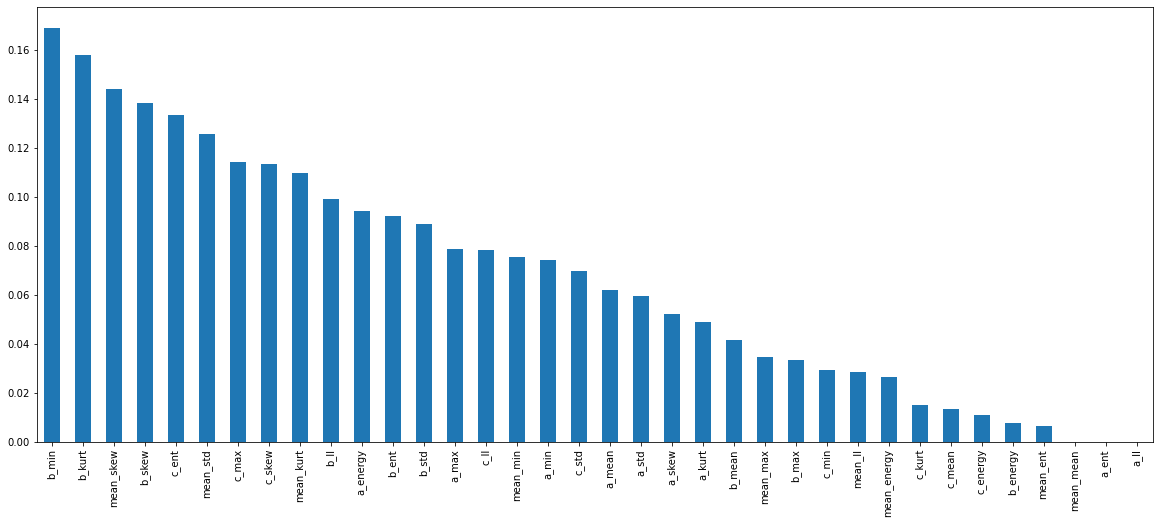

In [9]:
#Pplot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [12]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# select top 10 features using mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(feature, labels)
print(X_selected.shape)

(100, 10)


## Fit and Predict

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from sklearn.metrics import classification_report 

"""
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 150, 200], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9, 12, 15], 
    'max_leaf_nodes': [3, 6, 9, 12, 15], 
} 
"""
param_grid = { 
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9, 12, 15],
} 

grid_search = GridSearchCV(GradientBoostingClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(X_selected, labels) 
print(grid_search.best_estimator_) 

GradientBoostingClassifier(max_leaf_nodes=6)


In [157]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds for cross-validation
n_folds = 5

# Initialize an empty list to store cross-validation scores
scores = []

# Perform cross-validation
kf = KFold(n_folds, shuffle=True, random_state=42)
for train_index, test_index in kf.split(features):
    # Extract low-dimensional features for training and testing data
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train the random forest classifier on the training data
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the testing data
    predictions = rf_classifier.predict(X_test)

    # Calculate the accuracy score for the current fold
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)

# Calculate the average cross-validation score
average_score = np.mean(scores)
print('Average cross-validation accuracy:', average_score)

print(classification_report(predictions, y_test)) 

Average cross-validation accuracy: 0.82
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.75      0.86      0.80         7

    accuracy                           0.85        20
   macro avg       0.83      0.85      0.84        20
weighted avg       0.86      0.85      0.85        20



# Código train.py

In [ ]:
# -*- coding: utf-8 -*-



import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import ruptures as rpt
import json
import pywt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import pandas as pd


### if __name__ == '__main__':  # bei multiprocessing auf Windows notwendig

training_folder  = "../../training"

print('Loading Dataset')
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(training_folder) # Importiere EEG-Dateien, zugehörige Kanalbenennung, Sampling-Frequenz (Hz) und Name (meist fs=256 Hz), sowie Referenzsystem
print('Dataset loaded')

# Código da Sophia (Features)
import numpy as np
from scipy.stats import kurtosis, skew
import antropy as ant

feature = np.zeros((len(ids),(27))) # Empty array for all 9 features for every montage of every id
for i,_id in enumerate(ids):
    # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], data[i])
    _fs = sampling_frequencies[i]
    id_feature = np.zeros(27)
        
    m = 0
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        """Feature calculation"""
        sig_min = np.min(signal_filter) # Min
        sig_max = np.max(signal_filter) # Max
        sig_mean = np.mean(signal_filter) # Mean
        sig_ll = np.sum(np.abs(np.diff(signal_filter))) # Line Length
        sig_std = np.std(signal_filter) #Std Dev
        sig_kurtosis = kurtosis(signal_filter.tolist()) #Kurtosis
        sig_skew = skew(signal_filter.tolist()) #Skewness
        sig_en = np.mean(signal_filter**2) #Energy 
        sig_entspec = ant.spectral_entropy(signal_filter,fs,method='fft') # Entropy Spectral
        
        id_feature[m:(m+9)] = np.array([sig_min, sig_max, sig_mean, sig_ll, sig_std, sig_kurtosis, sig_skew, sig_en, sig_entspec])
        m += 9
    
    id_feature[27:36] = mean_features
    
    feature[i,:] = id_feature
    
labels = np.array(eeg_labels, dtype=int)[:,0]

from sklearn.feature_selection import SelectKBest, mutual_info_classif

# select top 10 features using mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(feature, labels)

rf_classifier = rf = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_features="sqrt",  # Number of features to consider at each split
    max_depth=12,  # Maximum depth of each tree
    min_samples_leaf=4,  # Minimum number of samples required to be at a leaf node
)


rf_classifier.fit(X_selected, labels)

# Speichere Modell
joblib.dump(rf_classifier, 'model.joblib') 

'''
with open('model.json', 'w', encoding='utf-8') as f:
    json.dump(rf_classifier.get_params(), f, ensure_ascii=False, indent=4)
    print('Seizure Detektionsmodell wurde gespeichert!')
'''


# Código predict.py

In [ ]:
# -*- coding: utf-8 -*-
"""

Skript testet das vortrainierte Modell


@author:  Maurice Rohr, Dirk Schweickard
"""


import numpy as np
import json
import os
from typing import List, Tuple, Dict, Any
from wettbewerb import get_3montages

# Pakete aus dem Vorlesungsbeispiel
import mne
from scipy import signal as sig
import ruptures as rpt
import pywt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib



###Signatur der Methode (Parameter und Anzahl return-Werte) darf nicht verändert werden
def predict_labels(channels : List[str], data : np.ndarray, fs : float, reference_system: str, model_name : str='model.joblib') -> Dict[str,Any]:
    '''
    Parameters
    ----------
    channels : List[str]
        Namen der übergebenen Kanäle
    data : ndarray
        EEG-Signale der angegebenen Kanäle
    fs : float
        Sampling-Frequenz der Signale.
    reference_system :  str
        Welches Referenzsystem wurde benutzt, "Bezugselektrode", nicht garantiert korrekt!
    model_name : str
        Name eures Models,das ihr beispielsweise bei Abgabe genannt habt. 
        Kann verwendet werden um korrektes Model aus Ordner zu laden
    Returns
    -------
    prediction : Dict[str,Any]
        enthält Vorhersage, ob Anfall vorhanden und wenn ja wo (Onset+Offset)
    '''

#------------------------------------------------------------------------------
# Euer Code ab hier  

    # Initialisiere Return (Ergebnisse)
    seizure_present = True # gibt an ob ein Anfall vorliegt
    seizure_confidence = 0.5 # gibt die Unsicherheit des Modells an (optional)
    onset = 4.5   # gibt den Beginn des Anfalls an (in Sekunden)
    onset_confidence = 0.99 # gibt die Unsicherheit bezüglich des Beginns an (optional)
    offset = 999999  # gibt das Ende des Anfalls an (optional)
    offset_confidence = 0   # gibt die Unsicherheit bezüglich des Endes an (optional)
    '''
    # Hier könnt ihr euer vortrainiertes Modell laden (Kann auch aus verschiedenen Dateien bestehen)
    with open(model_name, 'rb') as f:  
        parameters = json.load(f)         # Lade simples Model (1 Parameter)
    '''
    rf_classifier = joblib.load(model_name)
    
     # Berechne Montage
    _montage, _montage_data, _is_missing = get_3montages(channels[i], data[i])
    _fs = sampling_frequencies[i]
    id_feature = np.zeros(36)
    
    sum_min = 0
    sum_max = 0
    sum_mean = 0
    sum_ll = 0
    sum_std = 0
    sum_kurtosis = 0
    sum_skew = 0
    sum_en = 0
    sum_entspec = 0
        
    m = 0
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Notch-Filter to compensate net frequency of 50 Hz
        signal_notch = mne.filter.notch_filter(x=signal, Fs=_fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Bandpassfilter between 0.5Hz and 70Hz to filter out noise
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=_fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        """Feature calculation"""
        sig_min = np.min(signal_filter) # Min
        sig_max = np.max(signal_filter) # Max
        sig_mean = np.mean(signal_filter) # Mean
        sig_ll = np.sum(np.abs(np.diff(signal_filter))) # Line Length
        sig_std = np.std(signal_filter) #Std Dev
        sig_kurtosis = kurtosis(signal_filter.tolist()) #Kurtosis
        sig_skew = skew(signal_filter.tolist()) #Skewness
        sig_en = np.mean(signal_filter**2) #Energy 
        sig_entspec = ant.spectral_entropy(signal_filter,_fs,method='fft') # Entropy Spectral
        
        sum_min += sig_min
        sum_max += sig_max
        sum_mean += sig_mean
        sum_ll += sig_ll
        sum_std += sig_std
        sum_kurtosis += sig_kurtosis
        sum_skew += sig_skew
        sum_en += sig_en
        sum_entspec += sig_entspec
        
        id_feature[m:(m+9)] = np.array([sig_min, sig_max, sig_mean, sig_ll, sig_std, sig_kurtosis, sig_skew, sig_en, sig_entspec])
        m += 9
    
    sum_features = np.array([sum_min, sum_max, sum_mean, sum_ll, sum_std, sum_kurtosis, sum_skew, sum_en, sum_entspec])
    mean_features = sum_features/3
    id_feature[27:36] = mean_features
    
    feature[i,:] = id_feature
    
    seizure_present = rf_classifier.predict(feature)
    #seizure_present = seizure_present[0]

#------------------------------------------------------------------------------  
    prediction = {"seizure_present":seizure_present,"seizure_confidence":seizure_confidence,
                   "onset":onset,"onset_confidence":onset_confidence,"offset":offset,
                   "offset_confidence":offset_confidence}
  
    return prediction # Dictionary mit prediction - Muss unverändert bleiben!